#### Load data

In [1]:
import numpy as np
import pandas as pd
import ast

# Set the random seed for reproducibility
np.random.seed(0)

# Set n
n_str = '4'

# Load data
data = np.load('../data/forr_rand_fns_n' + n_str + '.npz')
# data = np.load('../data/forr_rand_fns_n' + n_str + '_change_basis.npz')

N = data['forr_f'].shape[2]

# Load indices for training set samples
df = pd.read_csv('../data/tr_inds.csv', header=None)
tr_idx = df.values
# Load indices for test set samples
df = pd.read_csv('../data/te_inds.csv', header=None)
te_idx = df.values

#### Build the model

In [17]:
from keras.utils import register_keras_serializable
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from keras.saving import load_model
from tensorflow import keras as tfk
import tensorflow as tf

@register_keras_serializable()
def euclidean_distance(vects):
    """
    Calculates the Euclidean distance between two vectors.

    Args:
        vects: A tuple of two vectors (x, y).

    Returns:
        The Euclidean distance between the two vectors.
    """
    x, y = vects
    return tfk.backend.sqrt(tfk.backend.maximum(tfk.backend.sum(tfk.backend.square(x - y), axis=1, keepdims=True), tfk.backend.epsilon()))

@register_keras_serializable()
def eucl_dist_output_shape(shapes):
    """
    Calculates the output shape of the Euclidean distance layer.

    Parameters:
    shapes (tuple): A tuple containing the shapes of the input tensors.

    Returns:
    tuple: A tuple representing the output shape of the Euclidean distance layer.
        The first dimension is the batch size, and the second dimension is 1.
    """
    shape1, shape2 = shapes
    return (shape1[0], 1)

def create_base_network(input_shape, N):
    """
    Creates a base network for a neural network model.

    Parameters:
    input_shape (tuple): The shape of the input data.

    Returns:
    keras.Model: The base network model.
    """
    input = Input(shape=input_shape)
    # x = Conv2D(32, (3, 3), activation='relu')(input)
    # x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = Conv2D(64, (3, 3), activation='relu')(x)
    # x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(input)
    x = Dense(N, activation='relu')(x) # use activation='sigmoid' if gradient-based optimization gives problems
    x = Dropout(0.1)(x)
    x = Dense(N, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(N, activation='relu')(x)
    return Model(input, x)

# Create the base network
base_network = create_base_network((N,), N)

# Create the left input and point to the base network
input_a = Input(shape=(N,))
vect_output_a = base_network(input_a)

# Create the right input and point to the base network
input_b = Input(shape=(N,))
vect_output_b = base_network(input_b)

# Measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# Specify the inputs and output of the model
model = Model([input_a, input_b], output)

# Compile the model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Save the weights of the model for easier resetting
# model.save_weights('model.weights.h5', overwrite=True)
# Save the model
# model.save('model.keras', overwrite=True)
model.save('model.keras', overwrite=True, include_optimizer=False)

#### Run model

In [18]:
# Create result list whose 8 columns are:
# train loss (mean, std), test loss (mean, std), train acc (mean, std), test acc (mean, std)
results_raw = np.zeros((50, 10, 4))
results = np.zeros((10, 8))

# Create training data + averages
n_samples, n_avg = tr_idx.shape
for i in range(n_samples):
    print("##### New sample: " + str(i+1) + " #####")
    for j in range(n_avg):
        print("----------------  Sample: " + str(i+1) + " | Average: " + str(j+1) + "  ----------------")
        # Load initial weights
        # model.load_weights('model.weights.h5')
        # Load model
        model = load_model('model.keras')
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
        # Prepare a test indices with 40 samples that are not in the training set with no repetitions
        # test_idx = np.random.choice([i for i in range(50) if i not in train_idx], 40, replace=False)
        # np.all(np.sort(ast.literal_eval(test_idx[0, 0])) == np.unique(ast.literal_eval(test_idx[0, 0])))
        # Training data
        train_idx = ast.literal_eval(tr_idx[i, j])
        x_train = np.zeros(((i+1)*2, 2, N))
        y_train = np.zeros((i+1)*2)
        for k in range(len(train_idx)):
            x_train[k, :, :] = data["forr_f"][train_idx[k], :, :]
            y_train[k] = 1
            x_train[k+(i+1), :, :] = data["rand_f"][train_idx[k], :, :]
            y_train[k+(i+1)] = 0
        # Test data
        test_idx = ast.literal_eval(te_idx[i, j])
        x_test = np.zeros((80, 2, N))
        y_test = np.zeros(80)
        for k in range(40):
            x_test[k, :, :] = data["forr_f"][test_idx[k]-1, :, :] # test file has 1-based indexing
            y_test[k] = 1
            x_test[k+40, :, :] = data["rand_f"][test_idx[k]-1, :, :] # test file has 1-based indexing
            y_test[k+40] = 0       
        # Reshape the data to fit the network input (samples, vector)
        x_train_1 = x_train[:, 0].reshape(-1, N)
        x_train_2 = x_train[:, 1].reshape(-1, N)
        x_test_1 = x_test[:, 0].reshape(-1, N)
        x_test_2 = x_test[:, 1].reshape(-1, N)

        # Train the model and store the history into results_raw
        history = model.fit([x_train_1, x_train_2], y_train, batch_size=128, epochs=300, validation_data=([x_test_1, x_test_2], y_test), verbose=0)
        results_raw[j, i, :] = [history.history['loss'][-1], history.history['val_loss'][-1], history.history['accuracy'][-1], history.history['val_accuracy'][-1]]
        del history

# Calculate the averages and standard deviations
for i in range(10):
    results[i, 0::2] = np.mean(results_raw[:, i, :], axis=0)
    results[i, 1::2] = np.std(results_raw[:, i, :], axis=0)

# np.savez('../data/forr_siamese_nn_n' + n_str + '.npz', results=results)
np.savez('../data/forr_siamese_nn_dropout_n' + n_str + '.npz', results=results)
# np.savez('../data/forr_siamese_nn_n' + n_str + '_change_basis.npz', results=results)
# np.savez('../data/forr_siamese_nn_dropout_n' + n_str + '_change_basis.npz', results=results)

##### New sample: 1 #####
----------------  Sample: 1 | Average: 1  ----------------
----------------  Sample: 1 | Average: 2  ----------------
----------------  Sample: 1 | Average: 3  ----------------
----------------  Sample: 1 | Average: 4  ----------------
----------------  Sample: 1 | Average: 5  ----------------
----------------  Sample: 1 | Average: 6  ----------------


KeyboardInterrupt: 

#### Plot

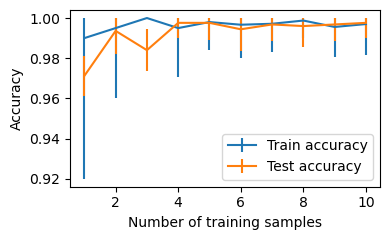

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 2.5))
# plt.errorbar(np.arange(1, 11), results[:, 0], yerr=results[:, 1], label='Train loss')
# plt.errorbar(np.arange(1, 11), results[:, 2], yerr=results[:, 3], label='Test loss')

# Calculate the upper errors
upper_train_error = np.minimum(results[:, 5], 1 - results[:, 4])
upper_test_error = np.minimum(results[:, 7], 1 - results[:, 6])
plt.errorbar(np.arange(1, 11), results[:, 4], yerr=[results[:, 5], upper_train_error], label='Train accuracy')
plt.errorbar(np.arange(1, 11), results[:, 6], yerr=[results[:, 7], upper_test_error], label='Test accuracy')

plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
# plt.ylim(0.9, 1)

plt.legend(loc='lower right')

plt.tight_layout()